In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,date
import calendar
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
import xgboost as xgb
from sklearn.metrics import classification_report
from lifetimes.utils  import summary_data_from_transaction_data

In [2]:
customer=pd.read_csv('C:/Users/Administrator/Desktop/FirstChoice/Customer1.csv')
invoice=pd.read_csv('C:/Users/Administrator/Desktop/FirstChoice/Final_invoice.csv')


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,1,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (9,10,14,15,21,41,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
invoice.rename(columns={'Custor No.':'Customer No.'},inplace=True)
invoice['Customer No.']=invoice['Customer No.'].apply(lambda x:x.strip())
customer['Customer No.']=customer['Customer No.'].apply(lambda x:str(x))

In [4]:
join=pd.merge(customer[['Customer No.','Business Partner','Occuption']],invoice[['Area / Locality','CITY','Claim No.','Cust Type','Customer No.','District','Insurance Company','Invoice Date','Job Card No','JobCard Date','KMs Reading','Make','Model','Pin code','ODN No.','Order Type','Plant Name1','Regn No','Total Amt Wtd Tax.']],how='inner', on ='Customer No.')

In [5]:
join.isnull().sum()
join['occuption']=join['occuption'].apply(lambda x:'Others' if x=='0' else x )

In [6]:
join['District']=join['District'].apply(lambda x:str(x))
join['District']=join['District'].apply(lambda x:x.lower())
city=join['District'].unique()

In [7]:
join['Model']=join['Model'].fillna(value='Others')
join['Insurance Company']=join['Insurance Company'].fillna(value='Others')
#join.isnull().sum()

In [8]:
join['Invoice Date']=join['Invoice Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date()) 
join['monthno']=join['Invoice Date'].apply(lambda x:x.month)

In [9]:
join['month']=join['monthno'].apply(lambda x:calendar.month_name[x])
join.rename(columns={'Invoice Date':'InvoiceDate'},inplace=True)
join.rename(columns={'Total Amt Wtd Tax.':'Revenue'},inplace=True)

In [89]:
summary=summary_data_from_transaction_data(join,'Customer No.','InvoiceDate',monetary_value_col='Revenue',observation_period_end='2016')

count    143988.000000
mean          0.905589
std           2.471246
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         322.000000
Name: frequency, dtype: float64
one time buyer:  62.39


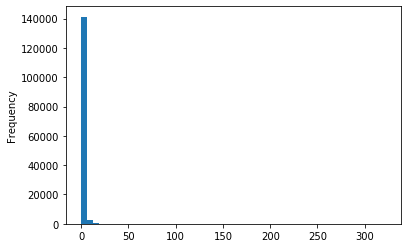

In [73]:
summary['frequency'].plot(kind='hist',bins=50)
print(summary['frequency'].describe())
one_time_buyer=round(sum(summary['frequency']==0)/float(len(summary))*(100),2)
print('one time buyer: ',one_time_buyer)

In [90]:
from lifetimes import BetaGeoFitter
bgf=BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'],summary['recency'],summary['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 143988 subjects, a: 2.01, alpha: 60.10, b: 4.59, r: 0.25>


In [91]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.251875,0.001811,0.248325,0.255425
alpha,60.098402,0.736112,58.655622,61.541182
a,2.008627,0.068723,1.873930,2.143323
b,4.585512,0.186215,4.220530,4.950494


In [92]:
t=10

summary['pred_num']=round(bgf.conditional_expected_number_of_purchases_up_to_time(t,summary['frequency'],summary['recency'], summary['T']),2)
summary.sort_values(by='pred_num', ascending=False).head(10)

,frequency,recency,T,monetary_value,pred_num
Customer No.,,,,,
E11206,209.0,461.0,462.0,6801.532823,3.88
14505,211.0,924.0,928.0,5631.779905,2.07
412,218.0,1351.0,1353.0,10890.746972,1.52
MFCC036,45.0,248.0,251.0,6174.676222,1.33
E11328,47.0,297.0,298.0,11052.191064,1.23
MFCWP01,175.0,1306.0,1334.0,6588.950857,0.90
56475,61.0,616.0,617.0,2950.046557,0.86
E11208,40.0,402.0,403.0,13901.418750,0.81
MFCCM14,106.0,1346.0,1359.0,19813.477075,0.71


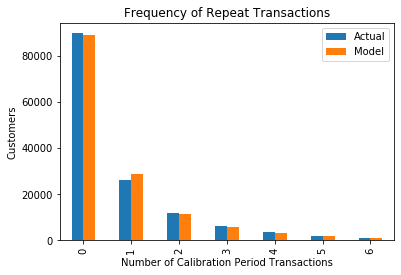

In [77]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [79]:

t = 500
individual = summary.loc[1]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [1] of <class 'int'>

In [93]:
summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.208483
frequency,0.208483,1.000000


In [94]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = summary[summary['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

  Customer No.  frequency  recency       T  monetary_value  pred_num
0            1        2.0    325.0  1332.0           0.000      0.00
1           10        4.0    439.0  1367.0        1831.440      0.00
2          100        1.0    156.0  1362.0        6632.670      0.00
3         1000        5.0    883.0  1327.0        1343.870      0.01
4        10000        5.0    922.0  1054.0         347.104      0.03
-----------------------------------------
The Number of Returning Customers are:  54157


In [95]:
shortlisted_customers = shortlisted_customers[shortlisted_customers['monetary_value']>0]
shortlisted_customers

,frequency,recency,T,monetary_value,pred_num
Customer No.,,,,,
10,4.0,439.0,1367.0,1831.440000,0.00
100,1.0,156.0,1362.0,6632.670000,0.00
1000,5.0,883.0,1327.0,1343.870000,0.01
10000,5.0,922.0,1054.0,347.104000,0.03
100001,2.0,210.0,256.0,1602.655000,0.05
...,...,...,...,...,...
MFCCM23,1.0,40.0,153.0,9771.110000,0.03
MFCCO14,4.0,157.0,1295.0,7052.875000,0.00
MFCCO15,3.0,77.0,1333.0,11384.436667,0.00


In [64]:
shortlisted_customers.dtypes

Customer No.       object
frequency         float64
recency           float64
T                 float64
monetary_value    float64
pred_num          float64
dtype: object

In [96]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 49857 subjects, p: 0.72, q: 2.23, v: 8197.19>


In [97]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 
print(ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).head(10))

Customer No.
1         2207.435553
10        2716.915977
100       5465.324425
1000      2221.890624
10000     1479.525229
100000    4784.039126
100001    3070.598770
100002    4784.039126
100003    4784.039126
100004    4784.039126
dtype: float64


In [99]:

summary['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']), 2)
summary.reset_index().head()

,Customer No.,frequency,recency,T,monetary_value,pred_num,pred_txn_value
0,1,2.0,325.0,1332.0,0.000,0.00,2207.44
1,10,4.0,439.0,1367.0,1831.440,0.00,2716.92
2,100,1.0,156.0,1362.0,6632.670,0.00,5465.32
3,1000,5.0,883.0,1327.0,1343.870,0.01,2221.89
4,10000,5.0,922.0,1054.0,347.104,0.03,1479.53


summary

In [100]:
#Calculate Customer Lifetime Value
summary['CLV'] = round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

summary.drop(summary.iloc[:, 0:6], inplace=True, axis=1)

#summary.sort_values(by='CLV', ascending=False).head(10).reset_index()

In [101]:
summary.sort_values(by='CLV', ascending=False).head(10).reset_index()

,Customer No.,CLV
0,E2003,637508.69
1,E11206,545780.20
2,412,448881.84
3,MFCCM14,381326.39
4,14505,294525.31
5,E11328,244904.94
6,E11208,225841.35
7,455,177299.84
8,69319,162728.72
9,MFCCM03,161895.38


In [88]:
summary

""
Customer No.
1
10
100
1000
10000
...
MFCCO14
MFCCO15
MFCCO16
